References: Chapter 17 of Geron's book. For 1-Dim plots, Keras tutorial : https://www.tensorflow.org/tutorials/generative/autoencoder

This file trains a modified VAE (with a different sampling layer and a different loss function) with the instances of the normal ECGs in the training data. Then, it measures the reconstruction loss for the ECGs in the test data. The reconstruction loss for the instances of the abnormal ECGs in the test data is higher. A threshold is determined based on the distribution of the reconstruction losses of the normal training data (threshold = mean + 2.5*std of this distribution). Then, if the reconstruction loss of a ECG in the test data is higher than this threshold, it is classified as abnormal. By comparing with the known labels of test data (with T for normal ECG(s) and F for abnormal ECG(s)), the confusion matrix and the accuracy is calculated.

Import the necessary libraries:

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.models import Model

Loading the ECG5000 data:

In [11]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


Parse the data so it can be split creating a variable containing the labels and another containing the data. 

In [12]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize the data so the features are treated equally:

In [13]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

The autoencoder is trained using only the normal rhythms, which are labeled in this dataset as 1. Here the normal rhythms is separated from the abnormal rhythms.

In [14]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels].numpy()
normal_test_data = test_data[test_labels].numpy()

anomalous_train_data = train_data[~train_labels].numpy()
anomalous_test_data = test_data[~test_labels].numpy()

Checking the shape of the normal data and abnormal data:

In [15]:
normal_test_data.shape, anomalous_test_data.shape

((560, 140), (440, 140))

Initialize K with the Keras backend to utilize it's methods in the Sampling function.

In [16]:
K = keras.backend

This Sampling layer takes two inputs: mean (μ) and log_var (γ). It uses the function K.random_normal() to sample a random vector (of the same shape as γ) from the Normal distribution, with mean 0 and standard deviation 1. Then it multiplies it by exp(γ/2) (which is equal to σ, as you can verify), and finally it adds μ and returns the result. This samples a codings vector from the Normal distribution with mean μ and standard deviation σ.

In [17]:
# Modified sampling layer with the addition of mean_2, log_var_2, and fraction p, with
# the appropriate change in the reparametrization trick to do stochastic 
# sampling from the superposition of the two MVN distributions, while allowing
# the 5 parallel layers containing the means and stds of the two MVNs and the fractions p's
# for each dimension to be trained via backpropogation of the error signal.
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean_1, log_var_1, mean_2, log_var_2, p = inputs
        return (K.random_normal(tf.shape(log_var_1)) * K.exp(log_var_1 / 2) + mean_1) * p 
        + (K.random_normal(tf.shape(log_var_2)) * K.exp(log_var_2 / 2) + mean_2)*(1 - p)

Create the encoder, using the Functional API because the model is not
entirely sequential:

In [18]:
# For details please see Geron's book. 
codings_size = 8   # The number of dimensions of the MVN distribution in the sampling layer

inputs = keras.layers.Input(shape=(normal_train_data.shape[1]))
z = keras.layers.Dense(32, activation="selu")(inputs)
z = keras.layers.Dense(16, activation="selu")(z)

# Adding output nodes (parallel layers) at the end of the encoder for means 
# and standard deviations of a second Multivariate Normal (MVN) distribution 
# in the dimensions of the coding size (here 32). In each of the dimensions,
# this first MVN is multiplied by a fraction p and added to the second MVN
# multiplied by 1 - p in each dimension.
# final distribution = p * first MVN + (1 - p) * second MVN
# Another parallel layer (set of nodes) is added to keep and train the fractions p's
# in each dimension 
codings_mean_1 = keras.layers.Dense(codings_size)(z)
codings_log_var_1 = keras.layers.Dense(codings_size)(z)
codings_mean_2 = keras.layers.Dense(codings_size)(z)
codings_log_var_2 = keras.layers.Dense(codings_size)(z)
codings_p = keras.layers.Dense(codings_size)(z)

# Sampling layer at the end of the encoder
# Modified sampling layer at the end of the encoder
codings = Sampling()([codings_mean_1, codings_log_var_1, codings_mean_2, codings_log_var_2, codings_p])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean_1, codings_log_var_1, codings_mean_2, codings_log_var_2, codings_p, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(16, activation="relu")(decoder_inputs)
x = keras.layers.Dense(32, activation="relu")(x)
outputs = keras.layers.Dense(normal_train_data.shape[1], activation="sigmoid")(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, _, _, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

# New latent loss function that will be added to the reconstruction binary cross-entropy loss
# The whole network (Encoder, sampling layer, and decoder) will train to minimize this loss
array1 = codings_log_var_1 - K.exp(codings_log_var_1) - K.square(codings_mean_1)
array2 = (codings_log_var_2 - K.exp(codings_log_var_2) - K.square(codings_mean_2)) # *  codings_ratio
sum1 = K.sum(1 + array1, axis=-1)
sum2 = K.sum(1 + array2, axis=-1)

latent_loss = -0.5 * tf.math.maximum(sum1, sum2)

# For the reconstruction loss binary cross-entropy loss is used. 
# For details please see Chapter 17 of Geron's book (Stacked AE and VAE sections) 
variational_ae.compile(loss="mae", optimizer="adam")

history = variational_ae.fit(normal_train_data, normal_train_data, epochs=100, batch_size=512,
                             validation_data=(test_data, test_data), shuffle=True)

Epoch 1/100
5/5 [==============================] - 1s 41ms/step - loss: 0.0767 - val_loss: 0.0579
Epoch 2/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0570 - val_loss: 0.0523
Epoch 3/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0533 - val_loss: 0.0518
Epoch 4/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0495 - val_loss: 0.0489
Epoch 5/100
5/5 [==============================] - 0s 12ms/step - loss: 0.0463 - val_loss: 0.0476
Epoch 6/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0427 - val_loss: 0.0454
Epoch 7/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0393 - val_loss: 0.0443
Epoch 8/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0363 - val_loss: 0.0417
Epoch 9/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0336 - val_loss: 0.0410
Epoch 10/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0314 - val_loss: 0.0394
Epoch 11/100
5/5 [========

Plotting the training and validation loss for each epoch of training:

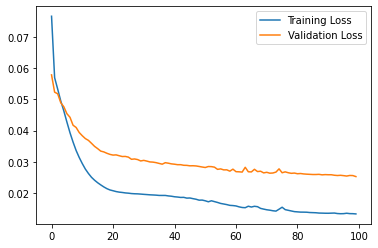

In [19]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

Plotting a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

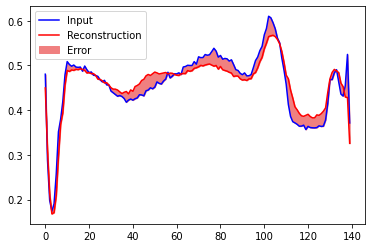

In [20]:
_, _, _, _, _, codings = variational_encoder(normal_test_data)
decoded_imgs = variational_decoder(codings)

plt.plot(normal_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Now, we will do the same for the anomalous data:

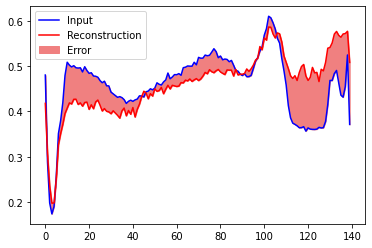

In [21]:
_, _, _, _, _, codings = variational_encoder(anomalous_test_data)
decoded_imgs = variational_decoder(codings)

plt.plot(normal_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

We now detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold , where  is the calculated for normal examples from the training set. We then will classify future examples as anomalous if the reconstruction error is higher than this threshold  from the training set.

Plotting the reconstruction error on normal ECGs from the training set

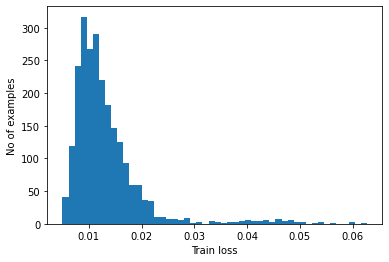

In [24]:
reconstructions = variational_ae.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [25]:
print("Mean: ", np.mean(train_loss))
print("Std: ", np.std(train_loss))

Mean:  0.013173575
Std:  0.0069607804


Initializing our threshold:

In [26]:
threshold_vae = np.mean(train_loss) + 2.5*np.std(train_loss)
print("Threshold: ", threshold_vae)

Threshold:  0.030575525481253862


Plotting the threshold and it can be observed that most data above threshold is abnormal.

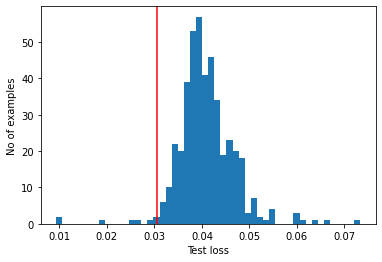

In [27]:
reconstructions = variational_ae.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.axvline(threshold_vae,c='r')
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [28]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  cf = confusion_matrix(labels, predictions)
  print("Confusion Matrix: \n prediction: F      T ")
  print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
  print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], labels[labels == False].shape[0]))
  print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], labels[labels == True].shape[0]))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [29]:
preds = predict(variational_ae, test_data, threshold_vae)
print_stats(preds, test_labels)

Confusion Matrix: 
 prediction: F      T 
             449   551
 label: F   [[433   7]    440
        T    [16   544]]   560
Accuracy = 0.977
Precision = 0.9872958257713249
Recall = 0.9714285714285714


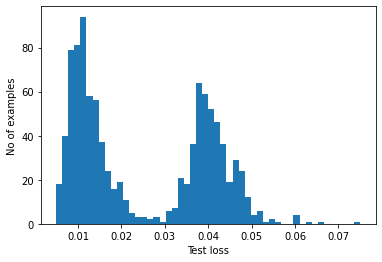

In [30]:
reconstructions = variational_ae.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions, test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()